Nom 1: Marc Martinez

Nom 2: Iker Cruz

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Repte 5: Gat o gos?

## Enunciat

En aquest repte crearem una **Xarxa Neuronal Convolucional** capaç de dir si una imatge correspon a la d'un gat o a la d'un gos.
Per poder fer això disposem d'un dataset format per 2000 fotos de gats i 2000 fotos de gossos. Aquest dataset es troba en [aquesta url](https://drive.google.com/file/d/1akESKTtn26-jiZGwMF1sVlDOMn8uQACu/view?usp=sharing).

### Pregunta 1
De quin tipus de problema es tracta?

In [31]:
!pip install visualkeras
!pip install gdown
!pip install pyyaml h5py


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Descarrega el dataset. Aquest fitxer és un zip que pots descomprimir amb la llibreria zipfile
from zipfile import ZipFile
# Importem les llibreries necessàries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from keras.models import Model
import visualkeras
import gdown
import zipfile
import os
import shutil
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib.request
from google.colab import files 
from tensorflow.keras.applications import VGG16

In [4]:
# Descarreguem dataset
#url = "https://drive.google.com/u/3/uc?id=1akESKTtn26-jiZGwMF1sVlDOMn8uQACu&export=download"
#output = "dataset.zip"
#gdown.download(url, output, quiet=False)
# Descomprimim
#shutil.unpack_archive("dataset.zip", "tmp")

In [5]:
# Defineix les variables train_dir, validation_dir, test_dir amb el path de 
# cada un dels directoris que contenen les imatges corresponents
train_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/tmp/cats_and_dogs_small/train/')
validation_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/tmp/cats_and_dogs_small/validation/')
test_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/tmp/cats_and_dogs_small/test/')

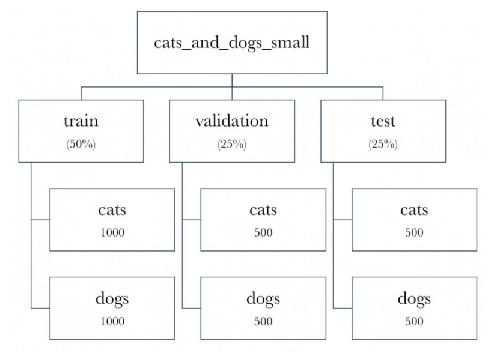

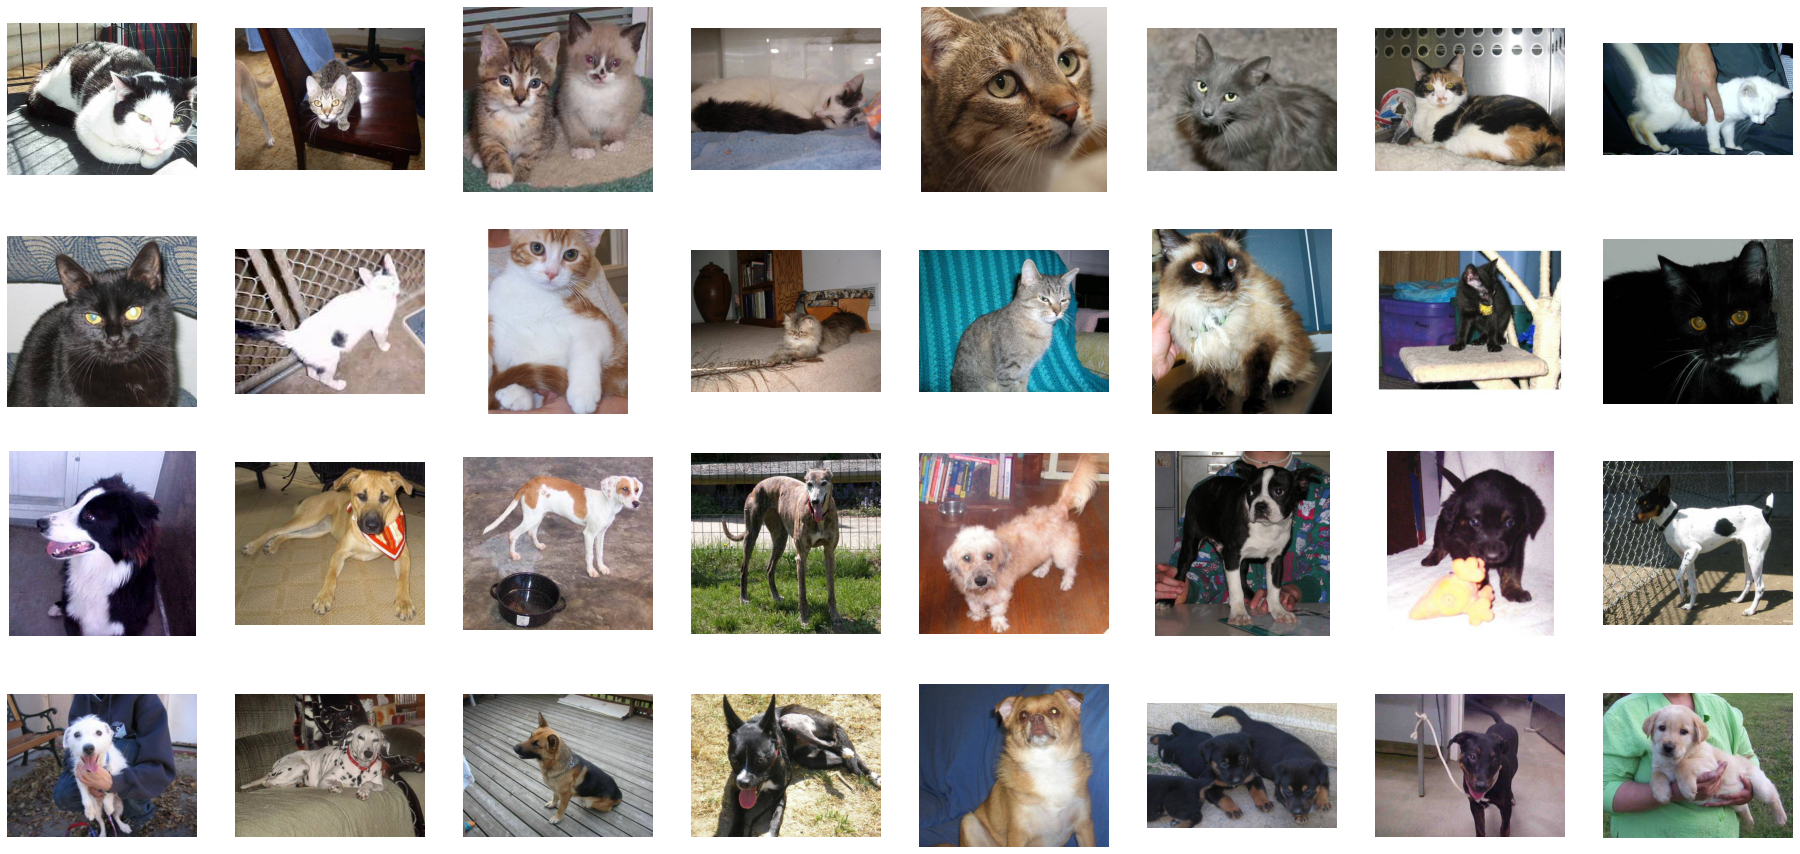

In [6]:
# Mostra les imatges de 16 gats i 16 gossos en matrius de 4x4
train_cats_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/tmp/cats_and_dogs_small/train/cats/')
train_dogs_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/tmp/cats_and_dogs_small/train/dogs/')
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)
fig = plt.gcf().set_size_inches(32,32)

next_cat_pix = [os.path.join(train_cats_dir,fname) for fname in train_cats_fnames[0:16]]
next_dog_pix = [os.path.join(train_dogs_dir,fname) for fname in train_dogs_fnames[0:16]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    sp = plt.subplot(8, 8, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
    
plt.show() 

### Pregunta 2
Quàntes neurones tindrem a la capa de sortida?

In [7]:
# Degut a la complexitat del problema i a la mida de les imatges necessitarem una xarxa amb més capes. Això ens
# serveix per augmentar la capacitat del model i per reduïr encara més la mida del mapa de característiques abans
# d'arribar a la capa final. 
#
# Crea una xarxa neuronal amb 4 capes convolucionals + MaxPooling de 32, 64, 128 i 128 filtres respectivament i
# de mida 3x3 (Conv) i 2x2 (MaxP). Abans de la capa de sortida tindrem una capa densa de 512 neurones. L'entrada
# al nostre model serà de 150x150x3, farem servir imatges a color de 150x150 pixels i cada pixel necessita 3 números
# per poder codificar la profunditat de color en RGB.
#
# Observa amb el mètode summary com els mapes de característiques van reduïnt la seva mida a mesura que avancen
# al llarg de les capes de la xarxa neuronal.
model = Sequential()

model.add(Conv2D(32,(3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(512,activation='relu'))

model.add(Dense(1,activation='sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

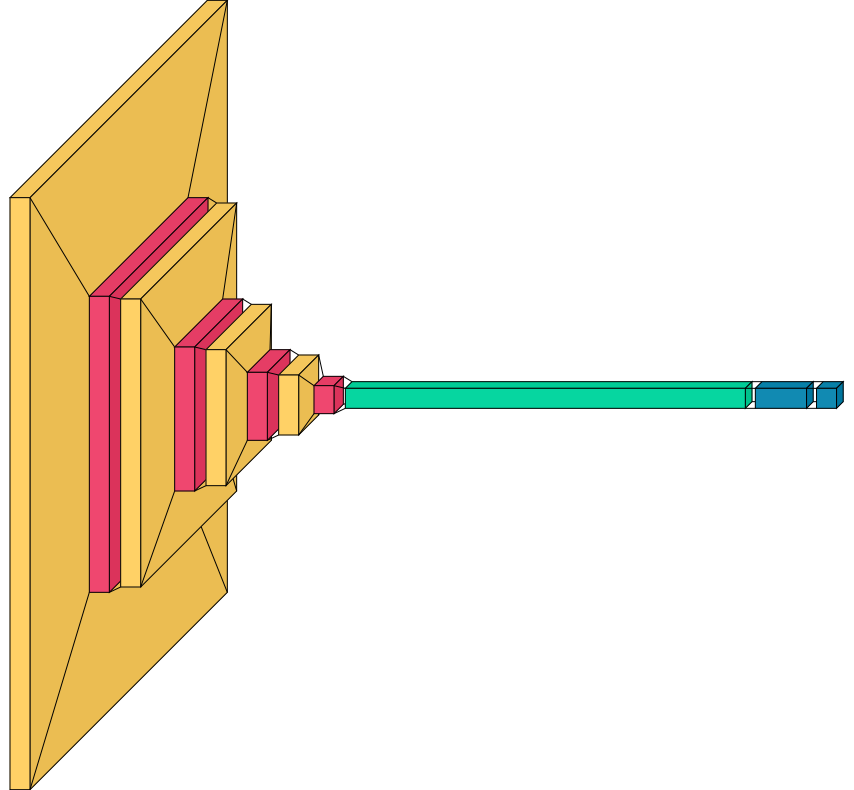

In [8]:
visualkeras.layered_view(model)

In [9]:
# Compil·la el model amb un optimitzador RMSprop amb un learning rate de 0,0001
model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate=0.0001), metrics = ['accuracy'])

In [10]:
# El dataset són imatges de diferents mides i amb pixels RGB compresos entre 0 i 255. Per poder
# realitzar l'entrenament necessitem imatges de 150x150 pixels i amb els valors RGB normalitzats
# entre 0 i 1.
#
# Pots realitzar aquesta operació fent servir ImageDataGenerator i aprofitar la jerarquia de directoris
# per definir la classe de cada una de les imatges.
#
# Exemple:
#
# train_datagen = ImageDataGenerator( rescale = 1.0/255. )
# train_generator = train_datagen.flow_from_directory(train_dir,
#                                                     batch_size=20,
#                                                     class_mode='binary',
#                                                     target_size=(150, 150))     
#
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

validation_datagen = ImageDataGenerator( rescale = 1.0/255. )
validation_generator =  validation_datagen.flow_from_directory( validation_dir,
                                                            batch_size=20,
                                                            class_mode  = 'binary',
                                                            target_size = (150, 150))

test_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_generator =  test_datagen.flow_from_directory( test_dir,
                                                            batch_size=20,
                                                            class_mode  = 'binary',
                                                            target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
# Realitza l'entrenament del model incolent les dades de validació, amb 50 epochs i iguala la sortida
# a la variable "history"
history = model.fit(train_generator, validation_data=validation_generator, steps_per_epoch=100, epochs=50, validation_steps=50, verbose=2)

Epoch 1/50
100/100 - 735s - loss: 0.6924 - accuracy: 0.5250 - val_loss: 0.6816 - val_accuracy: 0.5990 - 735s/epoch - 7s/step
Epoch 2/50
100/100 - 13s - loss: 0.6776 - accuracy: 0.5690 - val_loss: 0.6635 - val_accuracy: 0.5840 - 13s/epoch - 129ms/step
Epoch 3/50
100/100 - 14s - loss: 0.6624 - accuracy: 0.5830 - val_loss: 0.6564 - val_accuracy: 0.6070 - 14s/epoch - 140ms/step
Epoch 4/50
100/100 - 14s - loss: 0.6348 - accuracy: 0.6350 - val_loss: 0.6303 - val_accuracy: 0.6270 - 14s/epoch - 143ms/step
Epoch 5/50
100/100 - 13s - loss: 0.5996 - accuracy: 0.6740 - val_loss: 0.6128 - val_accuracy: 0.6570 - 13s/epoch - 134ms/step
Epoch 6/50
100/100 - 13s - loss: 0.5693 - accuracy: 0.7030 - val_loss: 0.5961 - val_accuracy: 0.6770 - 13s/epoch - 131ms/step
Epoch 7/50
100/100 - 13s - loss: 0.5499 - accuracy: 0.7120 - val_loss: 0.6010 - val_accuracy: 0.6890 - 13s/epoch - 131ms/step
Epoch 8/50
100/100 - 13s - loss: 0.5371 - accuracy: 0.7325 - val_loss: 0.5933 - val_accuracy: 0.6720 - 13s/epoch - 130m

### Pregunta 3
Quina és la precisió amb les dades d'entrenament? I amb les dades de validació?

Una diferència gran entre aquestes dues precisions ens podria estar indicant que s'ha produït sobreentrenament (overfitting).

<Figure size 432x288 with 0 Axes>

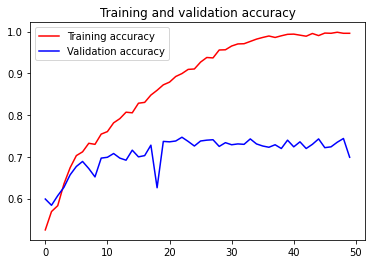

<Figure size 432x288 with 0 Axes>

In [12]:
# Fent servir la variable history, mostra un gràfic amb l'evolució de precisió i l'error 
# de les dades d'entrenament i les dades de validació
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

In [13]:
lossCNN, accuracyCNN = model.evaluate(test_generator)
print(f'perdua:',lossCNN)
print(f'precisió:',accuracyCNN)

50/50 [==============================] - 706s 14s/step - loss: 1.4144 - accuracy: 0.7150
perdua: 1.414352536201477
precisió: 0.7149999737739563


A les gràfiques podem veure com les linies de la precisió de les dades d'entrenament i de validació es separen aproximadament a partir de l'epoch 5. A la gràfica de l'error, podem observar que mentre amb les dades d'entrenament l'error continua baixant, amb les dades de validació l'error s'estanca.

Això ens està indicant que a partir de aquest moment comença l'overfitting i el model ja no està millorant. És entrenament inútil.

La xarxa treballa bé amb les imatges amb les que ha estat entrenada però el seu rendiment baixa quan ha de fer prediccions amb imatges que no ha vist mai.

Si el resultat és satisfactori podriem aturar l'entrenement en aquest punt i quedar-nos amb el model obtingut. En cas contrari, hauríem de millorar el model o millorar el dataset.

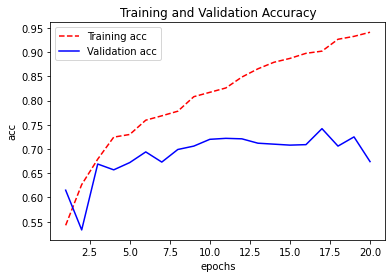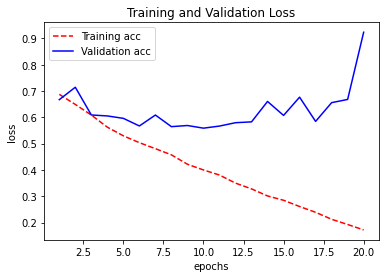

In [14]:
# Crea una miniapp amb un botó que ens permeti escollir una imatge del nostre ordinador,
# mostri aquesta imatge després d'adaptarla i comprobi si es tracta d'un gat o d'un gos.
#
# Després prova amb diferents imatges de gats i gossos obtingudes d'internet o de fotos
# realitzades a la vida real. Si tens mascota és una bona oportunitat per fer proves.
"""
imgenFile = files.upload()
name = list(imgenFile.keys())[0]

predict = load_img(name, target_size = (150, 150))   
predict_modified = img_to_array(predict)
predict_modified = predict_modified / 255
predict_modified = np.expand_dims(predict_modified, axis = 0)
result = model.predict(predict_modified)

if result[0][0] >= 0.5:
  prediction = 'dog'
  probability = result[0][0]
  print("probability = " + str(probability))
else:
  prediction = 'cat'
  probability = 1 - result[0][0]
  print ("probability = " + str(probability))

print("Prediction = " + prediction)"""

'\nimgenFile = files.upload()\nname = list(imgenFile.keys())[0]\n\npredict = load_img(name, target_size = (150, 150))   \npredict_modified = img_to_array(predict)\npredict_modified = predict_modified / 255\npredict_modified = np.expand_dims(predict_modified, axis = 0)\nresult = model.predict(predict_modified)\n\nif result[0][0] >= 0.5:\n  prediction = \'dog\'\n  probability = result[0][0]\n  print("probability = " + str(probability))\nelse:\n  prediction = \'cat\'\n  probability = 1 - result[0][0]\n  print ("probability = " + str(probability))\n\nprint("Prediction = " + prediction)'

#Repte 5v1: Gat o gos amb *Data Augmentation*

Com menys dades d'entrenament tinguem disponibles, menys possibilitats tindrem d'obtenir prediccions precises. Ara crearem un nou model fent servir tècniques de **Data Augmentation**. Aquest mètode ens permet generar més imatges a partir de les imatges disponibles fent transformacions aleatòries que ens generin imatges noves.

Aquestes transformacions poden ser operacions com rotar, invertir, voltear, zoom, etc. Ho farem amb la funció **[ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)** del paquet de preprocessat d'imatges de **Keras**.

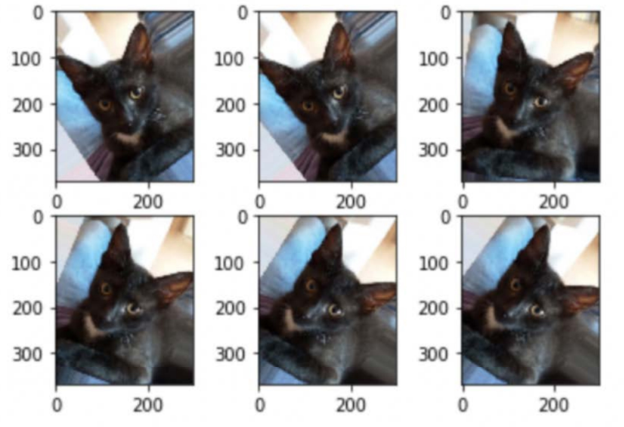

In [15]:
# Exemple d'ús
#
# En aquest cas no tindria sentit invertir verticalment la imatge perquè tindriem
# gats i gossos de cap per avall

train_datagen = ImageDataGenerator(
    rescale = 1./255,                     # Normalització dels pixels
    rotation_range = 40,                  # Rotació aleatòria fins a aquest angle
    width_shift_range = 0.2,              # Traslació aleatòria fins al 20% de l'amplada
    height_shift_range = 0.2,             # Traslació aleatòria fins al 20% de l'alçada
    shear_range = 0.2,                     # Transformació aleatòria de tall
    zoom_range = 0.2,                     # Zoom aleatoria fins al 20%
    horizontal_flip = True,               # Efecte mirall horitzontal
    fill_mode = 'nearest'                 # Estrategia per omplir els pixels de nova creació
)

# Genera la variable train_generator

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))



Found 2000 images belonging to 2 classes.


In [16]:
# Crea un nou model amb la mateixa estructura que en el cas anterior i
# realitza l'entrenament de 100 epochs amb les noves dades
modelNow = Sequential()

modelNow.add(Conv2D(32,(3,3), activation='relu', input_shape=(150,150,3)))
modelNow.add(MaxPooling2D(2,2))

modelNow.add(Conv2D(64,(3,3), activation='relu'))
modelNow.add(MaxPooling2D(2,2))

modelNow.add(Conv2D(128,(3,3), activation='relu'))
modelNow.add(MaxPooling2D(2,2))

modelNow.add(Conv2D(128,(3,3), activation='relu'))
modelNow.add(MaxPooling2D(2,2))

modelNow.add(Flatten())

modelNow.add(Dense(512,activation='relu'))

modelNow.add(Dense(1,activation='sigmoid'))


modelNow.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

In [17]:
modelNow.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate=0.0001), metrics = ['accuracy'])
history = modelNow.fit(train_generator, validation_data=validation_generator, steps_per_epoch=100, epochs=100, validation_steps=50, verbose=2)


Epoch 1/100
100/100 - 24s - loss: 0.6933 - accuracy: 0.5125 - val_loss: 0.6918 - val_accuracy: 0.4980 - 24s/epoch - 240ms/step
Epoch 2/100
100/100 - 23s - loss: 0.6861 - accuracy: 0.5545 - val_loss: 0.6826 - val_accuracy: 0.5270 - 23s/epoch - 226ms/step
Epoch 3/100
100/100 - 23s - loss: 0.6794 - accuracy: 0.5785 - val_loss: 0.6735 - val_accuracy: 0.5760 - 23s/epoch - 228ms/step
Epoch 4/100
100/100 - 21s - loss: 0.6736 - accuracy: 0.5795 - val_loss: 0.6587 - val_accuracy: 0.6280 - 21s/epoch - 213ms/step
Epoch 5/100
100/100 - 23s - loss: 0.6675 - accuracy: 0.5945 - val_loss: 0.6563 - val_accuracy: 0.6170 - 23s/epoch - 226ms/step
Epoch 6/100
100/100 - 23s - loss: 0.6607 - accuracy: 0.5915 - val_loss: 0.6393 - val_accuracy: 0.6300 - 23s/epoch - 227ms/step
Epoch 7/100
100/100 - 21s - loss: 0.6506 - accuracy: 0.6340 - val_loss: 0.6730 - val_accuracy: 0.5570 - 21s/epoch - 213ms/step
Epoch 8/100
100/100 - 22s - loss: 0.6317 - accuracy: 0.6415 - val_loss: 0.6089 - val_accuracy: 0.6580 - 22s/epo

<Figure size 432x288 with 0 Axes>

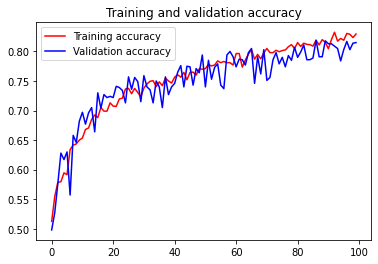

<Figure size 432x288 with 0 Axes>

In [18]:
# Mostra el gràfic amb l'evolució de la precisió i l'error de les dades 
# d'entrenament i les dades de validació
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

### Pregunta 5
A partir de quin epoch es produeix el sobreentrenament?

In [19]:
# Fes l'avaluació del model amb les dades de test

lossDA, accuracyDA = modelNow.evaluate(test_generator)
print(f'perdua:',lossDA)
print(f'precisió:',accuracyDA)

50/50 [==============================] - 4s 79ms/step - loss: 0.4385 - accuracy: 0.7960
perdua: 0.43850451707839966
precisió: 0.7960000038146973


#Repte 5v2: Gat o gos amb *Feature Extraction*

En aquesta versió del model farem servir la tècnica **Transfer Learning** per millorar encara més la precisió del nostre model, en concret l'estratègia **Feature Extraction**. Aprofitarem una xarxa preentrenada anomenada **VGG16** que tenim disponible als paquets de Keras. Aquesta és una CNN entrenada amb 1 milió d'imatges classificades en 1000 classes diferents.

In [20]:


# Creem un model a partir de VGG16
pre_trained_model = VGG16(input_shape = (150,150,3),
                          include_top = False,
                          weights = 'imagenet'
                          )

# Mostra un resum de l'estructura de la CNN preentrenada
pre_trained_model.summary()
# Congelem les capes per a que no es modifiquin el pesos durant l'entrenament
for layer in pre_trained_model.layers:
  layer.trainable = False

# Podem crear el modelFE com si la CNN preentrenada fos una capa més. Afegirem
# una capa Flatten i una Dense de 256 neurones abans de la capa de sortida
modelFE = Sequential()
modelFE.add(pre_trained_model)
modelFE.add(Flatten())
modelFE.add(Dense(256,activation='relu'))
modelFE.add(Dense(1,activation='sigmoid'))

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

### Pregunta 6
Per què una part dels paràmetres són no entrenables? A quina part del model corresponen?

In [21]:
# Realitza l'entrenament del nou model amb 100 epochs i learning_rate de 0.0001
modelFE.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate=0.0001), metrics = ['accuracy'])
history = modelFE.fit(train_generator, validation_data=validation_generator, steps_per_epoch=100, epochs=100, validation_steps=50, verbose=2)

Epoch 1/100
100/100 - 26s - loss: 0.5388 - accuracy: 0.7255 - val_loss: 0.4519 - val_accuracy: 0.7780 - 26s/epoch - 259ms/step
Epoch 2/100
100/100 - 24s - loss: 0.4252 - accuracy: 0.8065 - val_loss: 0.3367 - val_accuracy: 0.8480 - 24s/epoch - 239ms/step
Epoch 3/100
100/100 - 24s - loss: 0.3819 - accuracy: 0.8215 - val_loss: 0.3476 - val_accuracy: 0.8460 - 24s/epoch - 238ms/step
Epoch 4/100
100/100 - 24s - loss: 0.3640 - accuracy: 0.8355 - val_loss: 0.2735 - val_accuracy: 0.8890 - 24s/epoch - 235ms/step
Epoch 5/100
100/100 - 24s - loss: 0.3556 - accuracy: 0.8435 - val_loss: 0.2536 - val_accuracy: 0.8960 - 24s/epoch - 242ms/step
Epoch 6/100
100/100 - 23s - loss: 0.3359 - accuracy: 0.8475 - val_loss: 0.2481 - val_accuracy: 0.8950 - 23s/epoch - 230ms/step
Epoch 7/100
100/100 - 24s - loss: 0.3562 - accuracy: 0.8495 - val_loss: 0.2550 - val_accuracy: 0.8940 - 24s/epoch - 236ms/step
Epoch 8/100
100/100 - 24s - loss: 0.3195 - accuracy: 0.8530 - val_loss: 0.2828 - val_accuracy: 0.8820 - 24s/epo

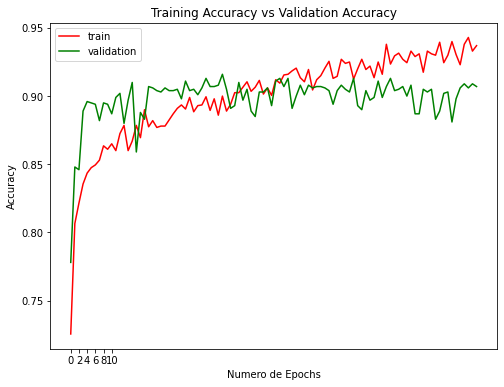

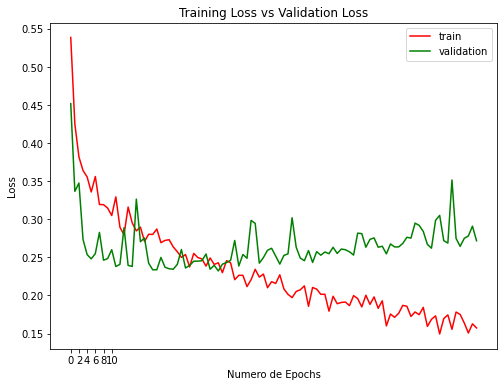

In [25]:
# Mostra el gràfic amb l'evolució de la precisió i l'error de les dades 
# d'entrenament i les dades de validació

plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Numero de Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Numero de Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()

### Pregunta 7
A partir de quin epoch es produeix el sobreentrenament?

In [26]:
# Fes l'avaluació del model amb les dades de test
lossFE, accuracyFE = modelFE.evaluate(test_generator)
print(f'perdua:',lossFE)
print(f'precisió:',accuracyFE)

50/50 [==============================] - 5s 92ms/step - loss: 0.2389 - accuracy: 0.9130
perdua: 0.2389495074748993
precisió: 0.9129999876022339


#Repte 5v3: Gat o gos amb *Fine-Tuning*


In [27]:
# Crea un nou model a partir del model pre-entrenat VGG16 i entrena'l amb la
# tècnica Fine-Tuning. Has de introduir el valor True el paràmetre layer.trainable
# de totes les capes 'block5'. Pots fer servir layer.name. En total hauries de tenir
# al voltant de 9M de paràmetres entrenables

model4 = Model(inputs=modelFE.inputs,outputs=modelFE.outputs)
for layer in pre_trained_model.layers:
  if(layer.name.startswith('block5')):
    layer.trainable = True
  
model4.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate=0.0001), metrics = ['accuracy'])


In [28]:
# Entrena el model durant 100 epochs
history = model4.fit(train_generator, validation_data=validation_generator, steps_per_epoch=100, epochs=100, validation_steps=50, verbose=2)

Epoch 1/100
100/100 - 27s - loss: 0.9216 - accuracy: 0.7480 - val_loss: 0.3035 - val_accuracy: 0.8620 - 27s/epoch - 267ms/step
Epoch 2/100
100/100 - 25s - loss: 0.3648 - accuracy: 0.8510 - val_loss: 0.4267 - val_accuracy: 0.8290 - 25s/epoch - 248ms/step
Epoch 3/100
100/100 - 24s - loss: 0.2871 - accuracy: 0.8820 - val_loss: 0.2092 - val_accuracy: 0.9180 - 24s/epoch - 241ms/step
Epoch 4/100
100/100 - 24s - loss: 0.2597 - accuracy: 0.8940 - val_loss: 0.3132 - val_accuracy: 0.8680 - 24s/epoch - 238ms/step
Epoch 5/100
100/100 - 24s - loss: 0.2580 - accuracy: 0.8945 - val_loss: 0.3286 - val_accuracy: 0.8680 - 24s/epoch - 241ms/step
Epoch 6/100
100/100 - 24s - loss: 0.2231 - accuracy: 0.9105 - val_loss: 0.3141 - val_accuracy: 0.9160 - 24s/epoch - 235ms/step
Epoch 7/100
100/100 - 24s - loss: 0.2708 - accuracy: 0.9075 - val_loss: 0.1706 - val_accuracy: 0.9380 - 24s/epoch - 238ms/step
Epoch 8/100
100/100 - 23s - loss: 0.2244 - accuracy: 0.9085 - val_loss: 0.1669 - val_accuracy: 0.9340 - 23s/epo

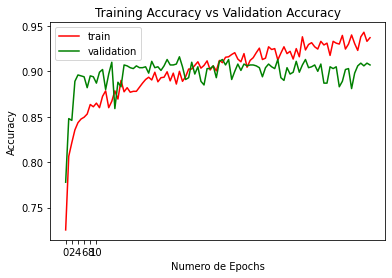

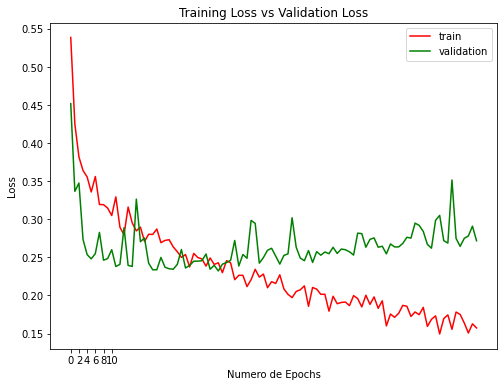

In [23]:
# Mostra el gràfic amb l'evolució de la precisió i l'error de les dades 
# d'entrenament i les dades de validació
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Numero de Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Numero de Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()

In [29]:
# Fes l'avaluació del model amb les dades de test
lossFT, accuracyFT = model4.evaluate(test_generator)
print(f'perdua:',lossFT)
print(f'precisió:',accuracyFT)


50/50 [==============================] - 4s 87ms/step - loss: 0.6876 - accuracy: 0.9240
perdua: 0.6875951886177063
precisió: 0.9240000247955322


### Pregunta 8
Quina ha estat la precisió amb cada un dels models?


*   CNN:
*   amb Data Augmentation:
*   amb Feature Extraction:
*   amb Fine-Tuning:

In [30]:
print(f'CNN: ',accuracyCNN)
print(f'Data Augmentation: ',accuracyDA)
print(f'Feature Extraction: ',accuracyFE)
print(f'Fine-Tuning: ',accuracyFT)

CNN:  0.7149999737739563
Data Augmentation:  0.7960000038146973
Feature Extraction:  0.9129999876022339
Fine-Tuning:  0.9240000247955322


# Com guardem els models creats?

Com hauràs pogut comprovar, els models que estem creant són cada cop més complexes i triguen més en realitzar l'entrenament. És per això que en certes situacions ens interesarà guardar el model per recuperar-lo en un altre moment.

In [33]:
# Guarda en un fitxer el model que millor ha realitzat les prediccions fent servir
# la funció save(). Aquesta funció fa servir el format hdf5.
!mkdir -p saved_model
model4.save('saved_model/my_model')
# Crea un model nou amb un altre nom i carrega la configuració del model guardat
# al fitxer fent servir la funció load_model()
model_Save = tf.keras.models.load_model('saved_model/my_model')
# Check its architecture
model_Save.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16_input (InputLayer)    [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [34]:
# Crea una miniapp com l'anterior però amb el model final que acabes de recuperar
imgenFile = files.upload()
name = list(imgenFile.keys())[0]

predict = load_img(name, target_size = (150, 150))   
predict_modified = img_to_array(predict)
predict_modified = predict_modified / 255
predict_modified = np.expand_dims(predict_modified, axis = 0)
result = model_Save.predict(predict_modified)

if result[0][0] >= 0.5:
  prediction = 'dog'
  probability = result[0][0]
  print("probability = " + str(probability))
else:
  prediction = 'cat'
  probability = 1 - result[0][0]
  print ("probability = " + str(probability))

print("Prediction = " + prediction)

Saving dog.1526.jpg to dog.1526.jpg
1/1 [==============================] - 1s 760ms/step
probability = 1.0
Prediction = dog
